https://www.kaggle.com/competitions/dataptmad1121

In [876]:
from sqlalchemy import create_engine
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

In [877]:
engine=create_engine('sqlite:///data/diamonds_train.db')
table_names = engine.table_names()
print(table_names)

['diamonds_city', 'diamonds_clarity', 'diamonds_color', 'diamonds_cut', 'diamonds_dimensions', 'diamonds_properties', 'diamonds_transactional']


/Users/albertofernandez/miniconda3/envs/proj_m3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  


In [878]:
diamonds_clarity = pd.read_sql_query("Select * from diamonds_clarity",engine)
diamonds_color = pd.read_sql_query("Select * from diamonds_color",engine)
diamonds_cut = pd.read_sql_query("Select * from diamonds_cut",engine)
diamonds_dimensions = pd.read_sql_query("Select * from diamonds_dimensions",engine)
diamonds_properties = pd.read_sql_query("Select * from diamonds_properties",engine)
diamonds_transactional = pd.read_sql_query("Select * from diamonds_transactional",engine)
diamonds_city = pd.read_sql_query("Select * from diamonds_city",engine)

In [879]:
query_1='''SELECT 
            propertis.index_id,
            clarity.clarity,
            color.color,
            cut.cut,
            dimensions.depth,
            dimensions.'table',
            dimensions.x,
            dimensions.y,
            dimensions.z,
            transactional.price,
            transactional.carat,
            city.city
        FROM diamonds_properties as propertis
        LEFT JOIN diamonds_clarity as clarity ON propertis.clarity_id = clarity.clarity_id
        LEFT JOIN diamonds_color as color ON propertis.color_id = color.color_id
        LEFT JOIN diamonds_cut as cut ON propertis.cut_id = cut.cut_id
        LEFT JOIN diamonds_dimensions as dimensions ON propertis.index_id = dimensions.index_id
        LEFT JOIN diamonds_transactional as transactional ON propertis.index_id = transactional.index_id
        LEFT JOIN diamonds_city as city ON transactional.city_id = city.city_id'''

In [880]:
train_df= pd.read_sql_query(query_1,engine)
test_df = pd.read_csv('data/diamonds_test.csv')#Con este hago la predición para subirlo a kaggle. 

In [881]:
train_df["price"].sort_values()

18377      326
9782       326
18381      327
20968      334
12084      335
         ...  
618      18795
25529    18797
29107    18806
3990     18818
7034     18823
Name: price, Length: 40455, dtype: int64

/Users/albertofernandez/miniconda3/envs/proj_m3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

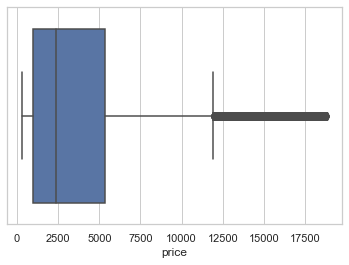

In [882]:
# Box Plot
sns.boxplot(train_df['price'])

In [885]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['J', 'I', 'H', 'G', 'F', 'E', 'D']])
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(train_df[["color"]])
train_df["color-encoded"] = encoder.transform(train_df[["color"]])
train_df.drop("color", axis = 1 , inplace = True)

encoder = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']])
encoder.fit(train_df[["cut"]])
train_df["cut-encoded"] = encoder.transform(train_df[["cut"]])
train_df.drop("cut", axis = 1 , inplace = True)

encoder = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
encoder.fit(train_df[["clarity"]])
train_df["clarity-encoded"] = encoder.transform(train_df[["clarity"]])
train_df.drop("clarity", axis = 1 , inplace = True)

In [886]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['J', 'I', 'H', 'G', 'F', 'E', 'D']])
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(test_df[["color"]])
test_df["color-encoded"] = encoder.transform(test_df[["color"]])
test_df.drop("color", axis = 1 , inplace = True)

# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']])
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(test_df[["cut"]])
test_df["cut-encoded"] = encoder.transform(test_df[["cut"]])
test_df.drop("cut", axis = 1 , inplace = True)

# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(test_df[["clarity"]])
test_df["clarity-encoded"] = encoder.transform(test_df[["clarity"]])
test_df.drop("clarity", axis = 1 , inplace = True)

In [887]:
target='price'
cat_features = ['cut-encoded','clarity-encoded','color-encoded']
num_features = ['depth','table','x','y','z','carat']
#Las columnas de categoria la paso a formato categoría como buena práctica.
for cat_feat in cat_features:
    train_df[cat_feat]=train_df[cat_feat].astype('category')
    test_df[cat_feat]=test_df[cat_feat].astype('category')

#Preparo el trainning. Separo el df en categorica y en numerico, y lo junto. 
cat_df = train_df[cat_features]#Paso las categoricas a 0 y 1. Df solo CATEGORICO.
num_df = train_df.loc[:,num_features]#Df solo NUMERICO.
df_train = pd.concat([cat_df, num_df], axis=1)#Aquí uno los dos df.


#Preparo el test
cat_df = test_df[cat_features]
num_df = test_df.loc[:,num_features]
df_test = pd.concat([cat_df, num_df], axis=1)
    
features = list(cat_df.columns) + list(num_df.columns)#Estas son mi features, sin el label o target. 

In [888]:
scaler = StandardScaler()
X=scaler.fit_transform(df_train.loc[:,features].values)
y=train_df[target]

In [889]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [890]:
#Entreno el modelo. 
model=RandomForestRegressor(random_state=42) 
model.fit(X=X,y=y)

RandomForestRegressor(random_state=42)

In [891]:
#Hago el scaler al Test, solo a los valores. 
X_test=scaler.transform(df_test.loc[:,features].values)

In [892]:
#REALIZO LA PREDICCION 
Price_predict = model.predict(X_test).clip(300,20000) #Esto es con el data entero
#Price_predict = model.predict(X_validation).clip(300,30000)

In [893]:
# RMSE calculation

#rmse = mean_squared_error(y_validation, Price_predict)**0.5
#rmse

In [894]:
#convertimos a dataframe y le damos forma
submission = pd.DataFrame({"id": test_df["id"],"price": Price_predict})

submission.to_csv('submission.csv', index=False)